In [ ]:
# OC - Projet 10
# Auteur : BERGERON Kévin
# Date début projet : 01/05/2023
# Deadline théorique : 18/08/2023
# Date fin de projet : 
# Temps alloué : 110 heures

Bonjour et bienvenue dans mon Jupyter Notebook du OC - Projet 10

En vous souhaitant bonne lecture.

Dans ce notebook, nous allons coder un programme de détection de faux billets.

# <span style="color:blue">I - Traitement des données (import et visualisation)</span>

In [148]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from itertools import product
import seaborn as sns
from datetime import datetime
from scipy import stats
import scipy as sp

import warnings
warnings.simplefilter("ignore")

# On définit nos données avec les chemins 'path' sur le local et on insère nos données dans des dataframes en lisant directement
# les fichiers CSV avec pandas
# ----------------------------------------------------------------------------------
billets = '/Users/Kévin/Downloads/OPENCLASSROOM/P10/billets.csv'
# ----------------------------------------------------------------------------------
df = pd.read_csv(billets, encoding='utf-8', sep=';')
# ----------------------------------------------------------------------------------
# Visualisation df
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [149]:
# Connaitre les dimensions du dataframe et le type de chaque champ
dim = df.shape
print('nb lignes df',dim[0],'/ nb colonnes df',dim[1])
df.dtypes
# ----------------------------------------------------------------------------------

# identification faite avec les nunique()
uniqueValues = df.nunique()
print("Nombre de valeurs uniques du df :\n",uniqueValues)

nb lignes df 1500 / nb colonnes df 7
Nombre de valeurs uniques du df :
 is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64


In [150]:
# Vérification doublons rapide

def doublons(df): 
    print(len(df) - len(df.drop_duplicates()), 'doublons dans le dataframe')
    
for i in [df]:
    doublons(i)

0 doublons dans le dataframe


In [151]:
# Identification des types de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Le jeu comporte 37 valeurs null pour la référence : margin_low. Il faut prendre une décision pour appréhender correctement notre jeu de données malgré ces 37 valeurs nulles.
Attribuer des valeurs à partir de moyennes serait certainement préjudiciable. Autant être exact sur notre conception du programme détecteur de faux billets et retirer du jeu de travail les lignes qui ne contiennent pas toute la donnée dont on a besoin.

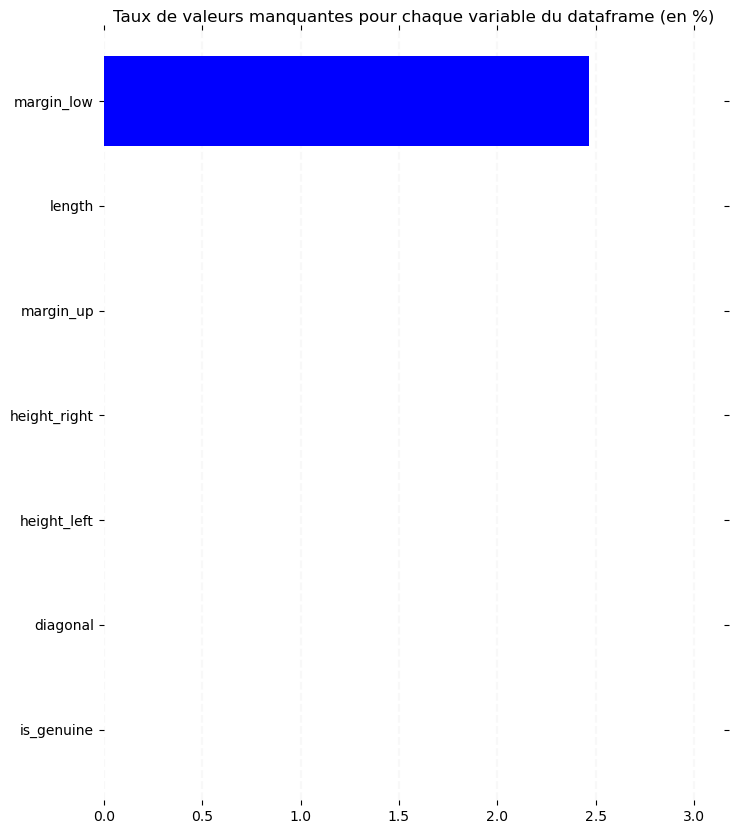

In [152]:
# Visualisation du pourcentage de null pour chaque variable du dataframe

size = df.shape
nan_values = df.isna().sum()

nan_values = nan_values.sort_values(ascending=True)*100/size[0]

ax = nan_values.plot(kind='barh', 
                     figsize=(8, 10), 
                     color='#0000FF',
                     zorder=2,
                     width=0.85)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", 
               which="both", 
               bottom="off", 
               top="off", 
               labelbottom="on", 
               left="off", 
               right="off", 
               labelleft="on")
ax.set_title("Taux de valeurs manquantes pour chaque variable du dataframe (en %)")
vals = ax.get_xticks()

for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

On pourrait partir du principe que 2.5% de valeurs manquantes, ce n'est pas significatif et donc retirer tout simplement ces valeurs nulles de notre jeu de données.

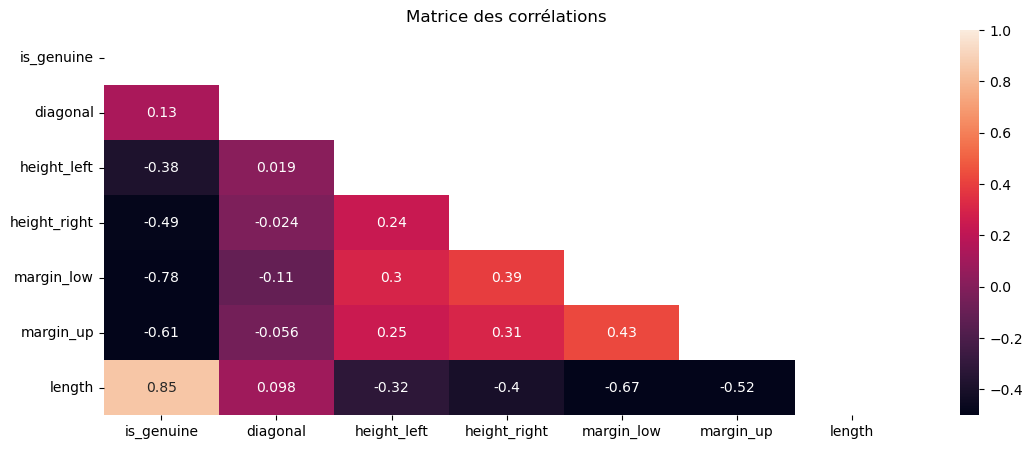

In [153]:
# Matrice des corrélations

matrix = df.corr()

mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
plt.title('Matrice des corrélations')
sns.heatmap(matrix, mask=mask, annot=True, vmin=-0.5, vmax=1)
plt.show()

On va pouvoir se servir de la variable length comme y = la cible puisqu'elle est très corrélée à is_genuine

In [154]:
sans_null = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index().drop(['index'], axis=1)
sans_null

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1458       False    171.75       104.38        104.17        4.42       3.09   
1459       False    172.19       104.63        104.44        5.27       3.37   
1460       False    171.80       104.01        104.12        5.51       3.36   
1461       False    172.06       104.28        104.06        5.17       3.46   
1462       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1458  111.28  
1459  110.97  
1460  111.95  
1461  112.25  
1462  112.07  

[1463 rows x 7 columns]

Partons plutôt sur une régression linéaire : c'est le bon moyen au vu de nos données pour implémenter des données semblant suivre la distribution sans fausser le jeu

In [155]:
test_df = df[df.isna().any(axis=1)]
test_df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53        103.96         NaN       2.71   
505         True    172.01       103.97        104.05         NaN       2.98   
611         True    171.80       103.68        103.49         NaN       3.30   
654         True    171.97       103.69        103.54         NaN       2.70   
675         True    171.60       103.85        103.91         NaN       2.56   
710         True    172.03       103.97        103.86         NaN       3.07   
739         True    172.07       103.74        103.76         NaN       3.09   
742         True    172.14       104.06        103.96         NaN       3.24   
780         True    172.41       103.95        103.79         NaN       3.13   
798         True    171.96       103.84        103.62         NaN       3.01   
844         True    171.62       104.14        104.49         NaN       2.99   
845         True    172.02       104.21        104.05         NaN       2.90   
871         True    171.37       104.07        103.75         NaN       3.07   
895         True    171.81       103.68        103.80         NaN       2.98   
919         True    171.92       103.68        103.45         NaN       2.58   
945         True    172.09       103.74        103.52         NaN       3.02   
946         True    171.63       103.87        104.66         NaN       3.27   
981         True    172.02       104.23        103.72         NaN       2.99   
1076       False    171.57       104.27        104.44         NaN       3.21   
1121       False    171.40       104.38        104.19         NaN       3.17   
1176       False    171.59       104.05        103.94         NaN       3.02   
1303       False    172.17       104.49        103.76         NaN       2.93   
1315       False    172.08       104.15        104.17         NaN       3.40   
1347       False    171.72       104.46        104.12         NaN       3.61   
1435       False    172.66       104.33        104.41         NaN       3.56   
1438       False    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

In [156]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(sans_null[['length']], sans_null['margin_low'])

LinearRegression()

In [157]:
test_df['margin_low'] = reg.predict(test_df[['length']])

In [158]:
r2 = reg.score(sans_null[['length']], sans_null[['margin_low']])
print('R² = ', r2)

R² =  0.444559270829349


In [159]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(sans_null[['height_right']], sans_null['margin_low'])
test_df['margin_low'] = reg.predict(test_df[['height_right']])
r2_nouveau = reg.score(sans_null[['height_right']], sans_null[['margin_low']])
print('R² = ', r2_nouveau)

R² =  0.15294759201240649


On explique seulement 44% de la variance de margin_low avec length, ce qui indique un modèle prédictif assez limité avec une part importante restante non expliquée par ce modèle. Mais l'on n'obtient pas mieux avec les autres variables.
Pour être encore plus sûr de notre jeu de données, une autre solution eût été de supprimer ces fameuses lignes comportant les données 'null' dans la variable margin_low

In [160]:
df = pd.concat([sans_null, test_df], ignore_index=True)

In [161]:
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95    4.520000       2.89   
1           True    171.46       103.36        103.66    3.770000       2.99   
2           True    172.69       104.48        103.50    4.400000       2.94   
3           True    171.36       103.91        103.94    3.620000       3.01   
4           True    171.73       104.28        103.46    4.040000       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    172.17       104.49        103.76    4.356655       2.93   
1496       False    172.08       104.15        104.17    4.684987       3.40   
1497       False    171.72       104.46        104.12    4.644947       3.61   
1498       False    172.66       104.33        104.41    4.877181       3.56   
1499       False    171.90       104.28        104.29    4.781084       3.24   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.21  
1496  112.29  
1497  110.31  
1498  111.47  
1499  111.49  

[1500 rows x 7 columns]

In [162]:
print(df[df.index.duplicated()])

Empty DataFrame
Columns: [is_genuine, diagonal, height_left, height_right, margin_low, margin_up, length]
Index: []


In [163]:
print(df.isna().sum())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [164]:
df.describe(include='all')

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1500.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485030   
std           NaN     0.305195     0.299462      0.325627     0.657295   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.020000   
50%           NaN   171.960000   104.040000    103.920000     4.320000   
75%           NaN   172.170000   104.230000    104.150000     4.862500   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

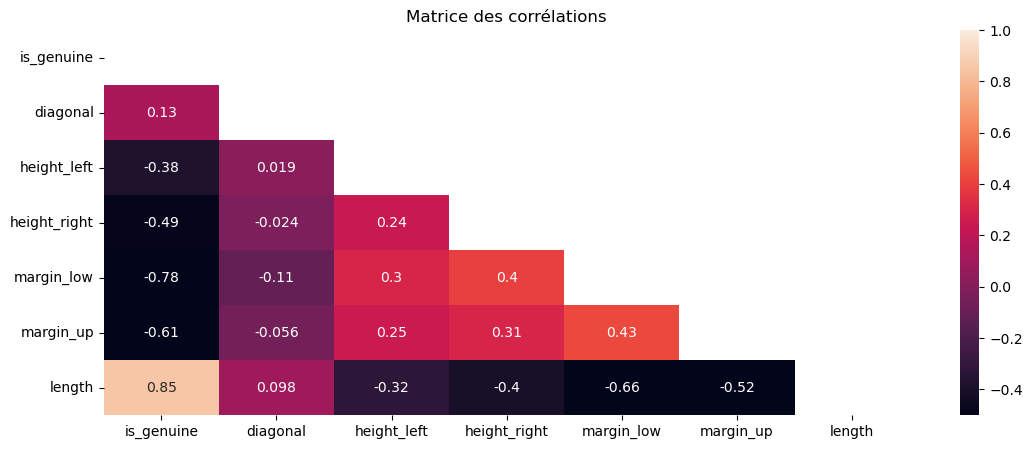

In [165]:
# Matrice des corrélations

matrix = df.corr()

mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
plt.title('Matrice des corrélations')
sns.heatmap(matrix, mask=mask, annot=True, vmin=-0.5, vmax=1)
plt.show()

Après vérification, cela n'a que très légèrement changé nos corrélations (puisque cela représente 2.5% du jeu on le rappelle) et ça a augmenté de 0.3 à 0.31 le lien de corrélation entre margin_low et height_left, ce qui paraît tout à fait logique aussi puisque désormais nous avons plus de données dans margin_low.

In [166]:
df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

Détection de variables non significatives

In [167]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

reg_multi = smf.ols('margin_low~+is_genuine+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     385.8
Date:                Tue, 30 May 2023   Prob (F-statistic):          3.01e-299
Time:                        15:16:37   Log-Likelihood:                -796.28
No. Observations:                1500   AIC:                             1607.
Df Residuals:                    1493   BIC:                             1644.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.7710      8

In [168]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

reg_multi = smf.ols('margin_low~+is_genuine+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     463.1
Date:                Tue, 30 May 2023   Prob (F-statistic):          1.56e-300
Time:                        15:16:42   Log-Likelihood:                -796.44
No. Observations:                1500   AIC:                             1605.
Df Residuals:                    1494   BIC:                             1637.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4524      5

On remarque qu'en retirant la variable 'diagonal', rien ne se passe au niveau du R², on pourrait également retirer la variable en question du jeu.
Nous allons la garder pour essayer d'accentuer l'efficacité de notre modèle mais celle-ci ne devrait pas changer beaucoup de paramètres du modèle au vu de son impact nul sur le R².

In [169]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Test d'ANOVA
model = smf.ols('length ~ is_genuine', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('ANOVA\np-value :', p, '\nstat (F) :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.'
         '\n\nConditions :'
         '\n1. Normalité des résidus\n2. Homoscédasticité')

ANOVA
p-value : 0.0 
stat (F) : 3876.654137828149
H1: one or more of the means of the samples are unequal.

Conditions :
1. Normalité des résidus
2. Homoscédasticité



Normalité des résidus (Shapiro)

stats : 0.9911649227142334 
p-value : 7.491955500427139e-08
H0 rejetée : distribution probablement pas normale


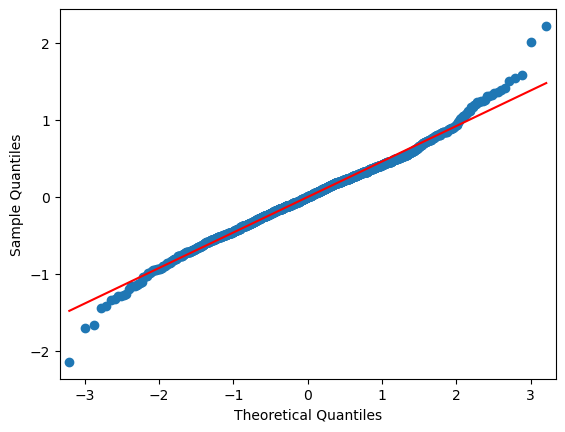

In [170]:
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

# Test de Shapiro sur les résidus
print('\nNormalité des résidus (Shapiro)')
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', stats.shapiro(model.resid)[1])
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(model.resid, line='s')
plt.show()

In [171]:
df_1 = df.copy()
df_1['is_genuine'] = df_1['is_genuine'].map({True:0, False:1})
df_1

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0              0    171.81       104.86        104.95    4.520000       2.89   
1              0    171.46       103.36        103.66    3.770000       2.99   
2              0    172.69       104.48        103.50    4.400000       2.94   
3              0    171.36       103.91        103.94    3.620000       3.01   
4              0    171.73       104.28        103.46    4.040000       3.48   
...          ...       ...          ...           ...         ...        ...   
1495           1    172.17       104.49        103.76    4.356655       2.93   
1496           1    172.08       104.15        104.17    4.684987       3.40   
1497           1    171.72       104.46        104.12    4.644947       3.61   
1498           1    172.66       104.33        104.41    4.877181       3.56   
1499           1    171.90       104.28        104.29    4.781084       3.24   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.21  
1496  112.29  
1497  110.31  
1498  111.47  
1499  111.49  

[1500 rows x 7 columns]

In [172]:
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95    4.520000       2.89   
1           True    171.46       103.36        103.66    3.770000       2.99   
2           True    172.69       104.48        103.50    4.400000       2.94   
3           True    171.36       103.91        103.94    3.620000       3.01   
4           True    171.73       104.28        103.46    4.040000       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    172.17       104.49        103.76    4.356655       2.93   
1496       False    172.08       104.15        104.17    4.684987       3.40   
1497       False    171.72       104.46        104.12    4.644947       3.61   
1498       False    172.66       104.33        104.41    4.877181       3.56   
1499       False    171.90       104.28        104.29    4.781084       3.24   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.21  
1496  112.29  
1497  110.31  
1498  111.47  
1499  111.49  

[1500 rows x 7 columns]

In [173]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Séparation des variables dépendante et indépendantes
y = df_1['is_genuine']
X = df_1[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]  # Remplacez X1, X2, X3 par les noms de vos variables indépendantes

# Ajout d'une colonne de constantes à la matrice des variables indépendantes
X = sm.add_constant(X)

# Régression linéaire
model = sm.OLS(y, X).fit()

# Calcul du VIF pour chaque variable indépendante
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

       Variable            VIF
0         const  593489.132073
1      diagonal       1.018285
2   height_left       1.157497
3  height_right       1.264464
4    margin_low       1.893143
5     margin_up       1.418260
6        length       2.104422


La variable 'const' est la constante ajoutée à la matrice des variables indépendantes et n'est pas significative en terme de multicolinéarité.
Les VIF des autres variables sont tous inférieurs à 5, ce qui tend à prouver qu'il n'y a pas de forte multicolinéarité entre ces variables.

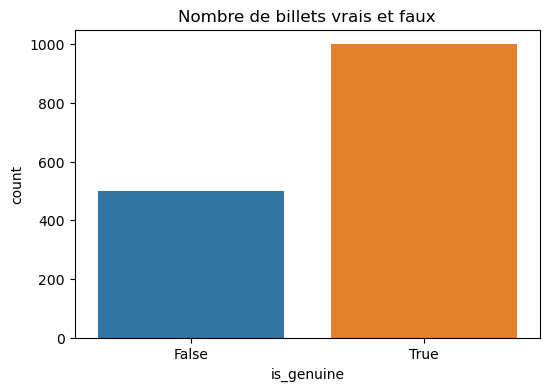

In [174]:
# Histogramme de la distribution

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()


Répartition des billets Vrais/Faux : 



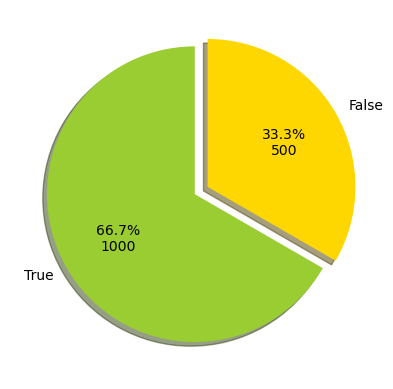

In [175]:
# Pie plot de la distribution

labels = df['is_genuine'].value_counts().index
sizes = df['is_genuine'].value_counts().values
colors = ['yellowgreen', 'gold', 'lightskyblue']
total = df['is_genuine'].value_counts().values.sum()
explode = (0, 0.1)
print("\nRépartition des billets Vrais/Faux : \n")

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(sizes, explode=explode, labels=labels, autopct=fmt, shadow=True, startangle=90, colors=colors)
plt.show()

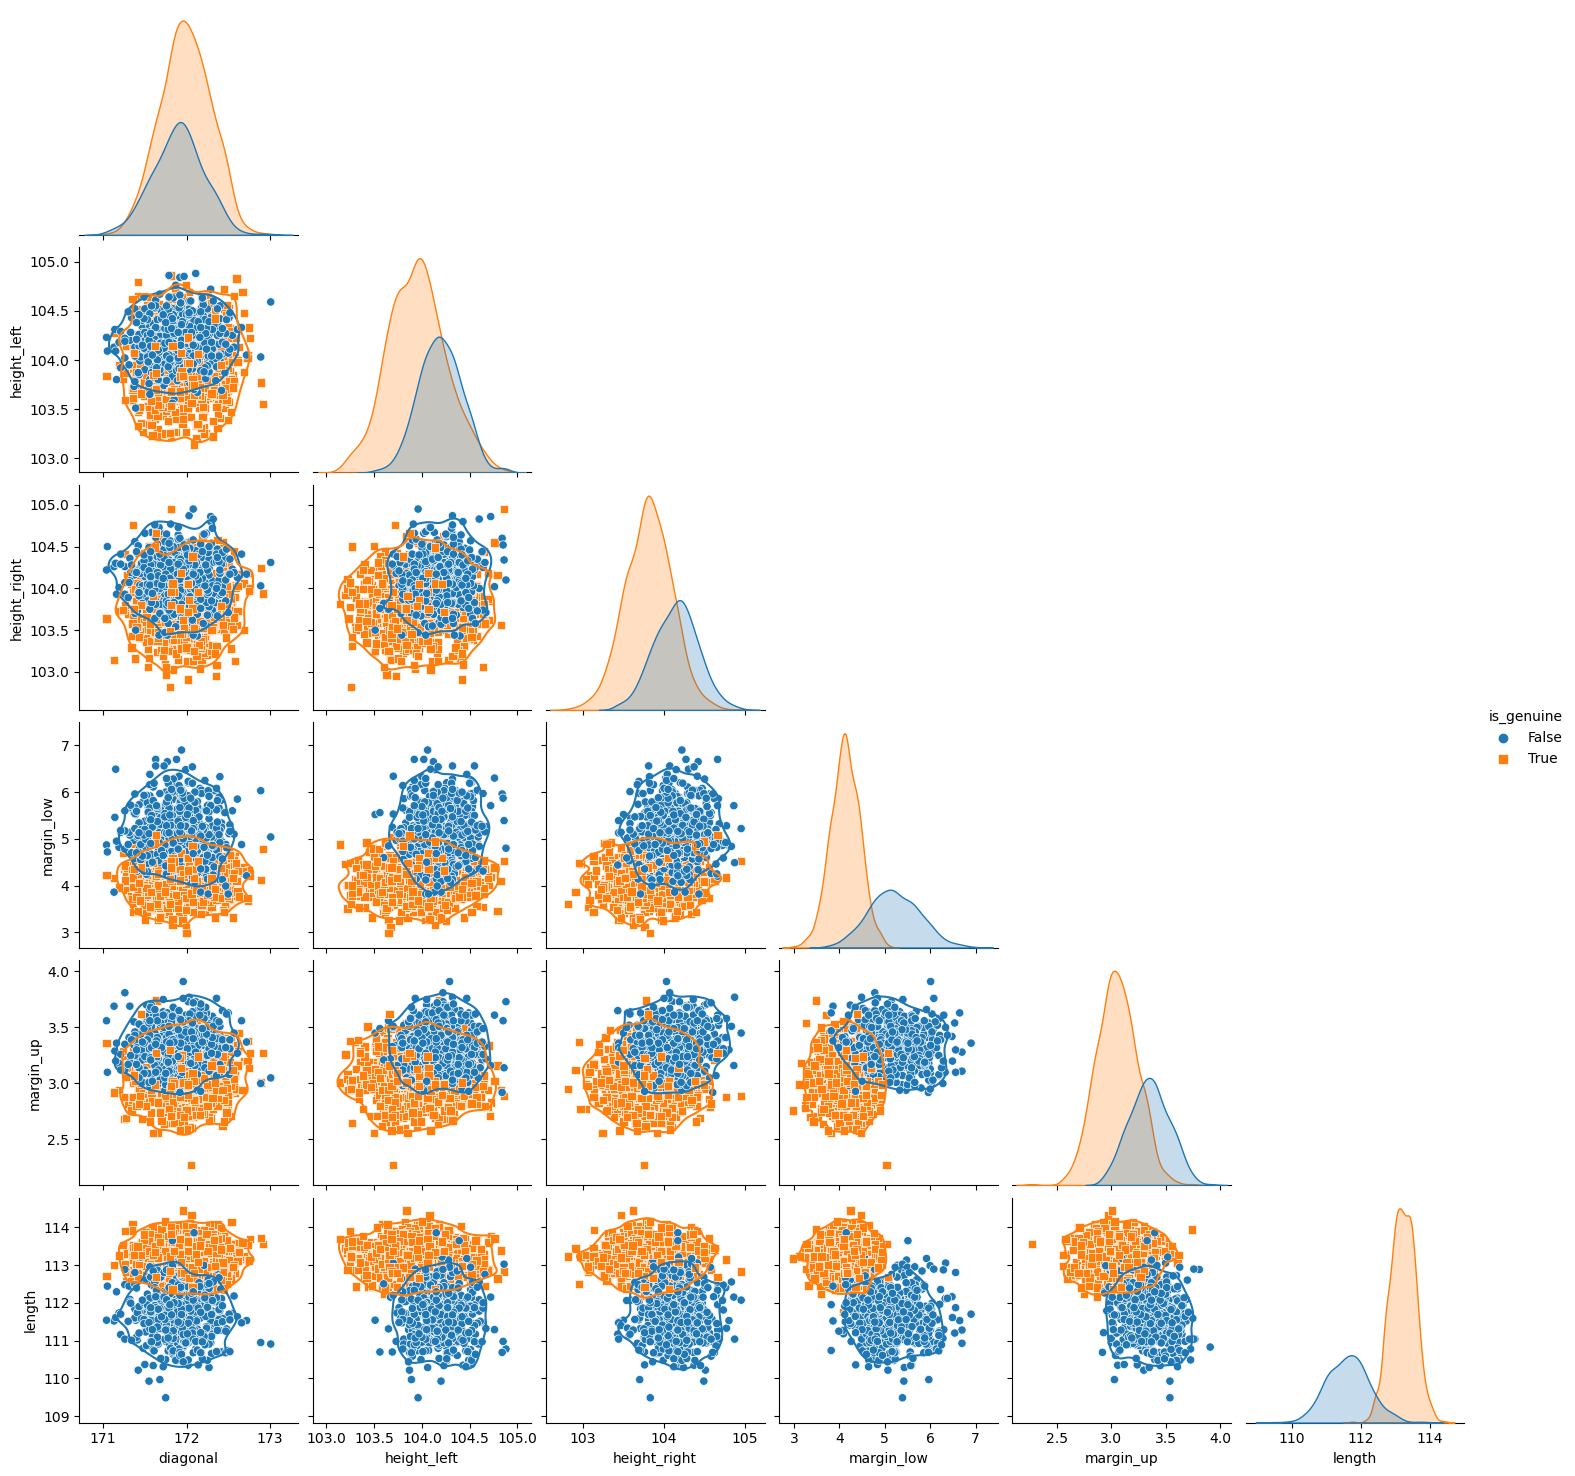

In [176]:
# Pairplot de la distribution

g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.2')
plt.show()

Les variables margin_low et length ont l'air d'être celles comportant le plus de disparités entre les vrais billets et les faux.
Ceci parce que les surfaces interposées entre True et False sont très peu étendues sur ces deux variables comme on peut le remarquer grâce aux pairs plots en bout de ligne.

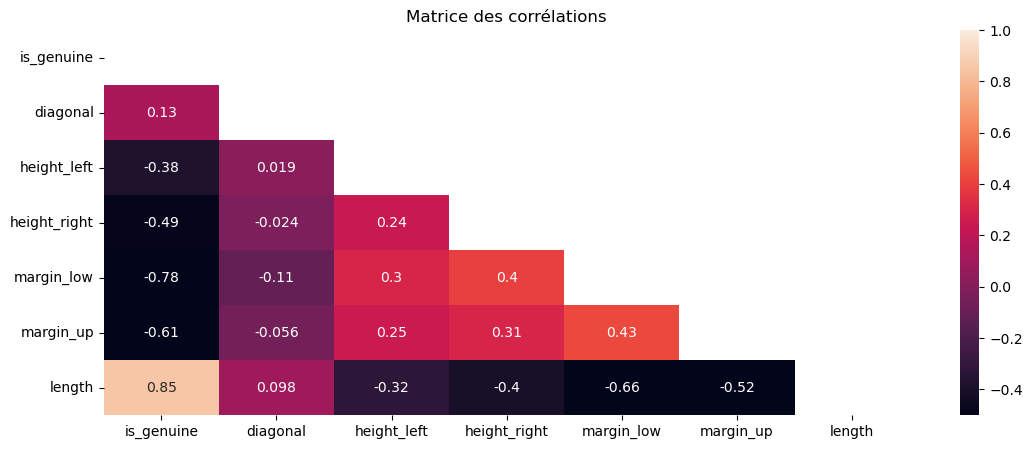

In [177]:
# Matrice des corrélations

matrix = df.corr()

mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(13, 5))
plt.title('Matrice des corrélations')
sns.heatmap(matrix, mask=mask, annot=True, vmin=-0.5, vmax=1)
plt.show()

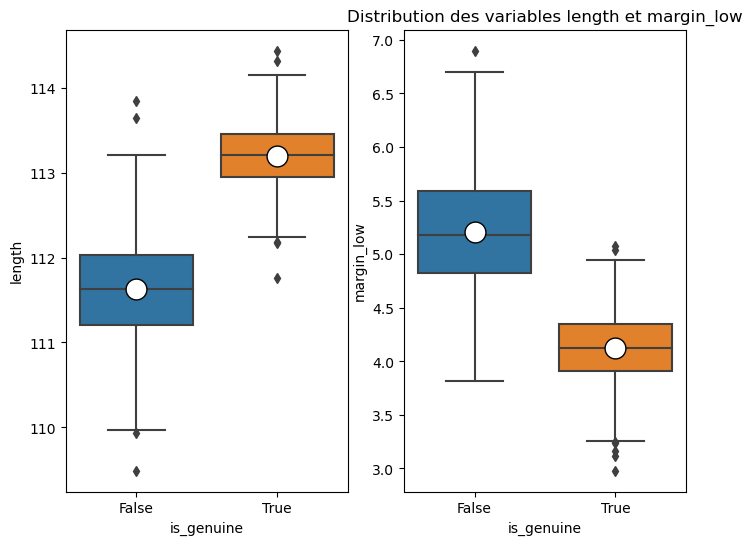

In [178]:
fig, ax = plt.subplots(1,2, figsize=(8,6))
meanprops = {"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"15"}
sns.boxplot(data=df, y='length', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[0])
sns.boxplot(data=df, y='margin_low', x='is_genuine', showmeans=True, meanprops=meanprops, ax=ax[1])
plt.title('Distribution des variables length et margin_low')
plt.show()

In [179]:
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [180]:
# Variables à standardiser

X = df.drop(['is_genuine'], axis=1)

In [181]:
scaler = StandardScaler()

In [182]:
scaler.fit(X)

StandardScaler()

In [183]:
X_scaled = scaler.transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.05321997, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08820073, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12940734, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.31648487, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67728928,  1.41767746,
        -0.15875038]])

In [184]:
# Df des valeurs standardisées

X_std = pd.DataFrame(X_scaled, columns=X.columns) # Valeurs standardisées
X_std

diagonal  height_left  height_right  margin_low  margin_up    length
0    -0.486540     2.774123      3.163240    0.053220  -1.128325  0.173651
1    -1.633729    -2.236535     -0.799668   -1.088201  -0.696799  0.471666
2     2.397823     1.504756     -1.291191   -0.129407  -0.912562  0.551901
3    -1.961498    -0.399294      0.060498   -1.316485  -0.610494  0.953075
4    -0.748754     0.836669     -1.414072   -0.677289   1.417677 -0.158750
...        ...          ...           ...         ...        ...       ...
1495  0.693427     1.538161     -0.492466   -0.195373  -0.955715 -1.683213
1496  0.398435     0.402412      0.767063    0.304313   1.072457 -0.445303
1497 -0.781531     1.437948      0.613462    0.243376   1.978661 -2.714803
1498  2.299493     1.003691      1.504349    0.596812   1.762898 -1.385197
1499 -0.191548     0.836669      1.135706    0.450563   0.382015 -1.362273

[1500 rows x 6 columns]

In [185]:
X_std.describe()

diagonal   height_left  height_right    margin_low     margin_up  \
count  1.500000e+03  1.500000e+03  1.500000e+03  1.500000e+03  1.500000e+03   
mean   1.464536e-14  4.791974e-14 -2.776801e-14 -4.911627e-16 -3.731090e-16   
std    1.000334e+00  1.000334e+00  1.000334e+00  1.000334e+00  1.000334e+00   
min   -3.010357e+00 -2.971432e+00 -3.380166e+00 -2.290497e+00 -3.803785e+00   
25%   -6.832007e-01 -6.999333e-01 -6.460667e-01 -7.077272e-01 -6.967992e-01   
50%    5.113189e-03  3.496326e-02 -9.420867e-04 -2.511589e-01 -4.951040e-02   
75%    6.934271e-01  6.696467e-01  7.056229e-01  5.744688e-01  6.840835e-01   
max    3.446683e+00  2.840932e+00  3.163240e+00  3.675328e+00  3.273239e+00   

             length  
count  1.500000e+03  
mean   1.402434e-15  
std    1.000334e+00  
min   -3.654697e+00  
25%   -7.433186e-01  
50%    3.226587e-01  
75%    7.582193e-01  
max    2.019053e+00

In [186]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean  0.0  0.0 -0.0 -0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

L'écart type des valeurs standardisées est bien proche de 1 pour toutes désormais.

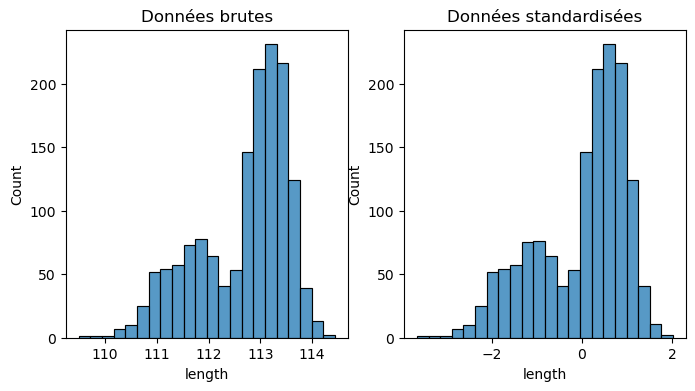

In [187]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df['length'], ax=ax[0])
sns.histplot(X_std['length'], ax=ax[1])
ax[0].title.set_text('Données brutes')
ax[1].title.set_text('Données standardisées')
plt.show()

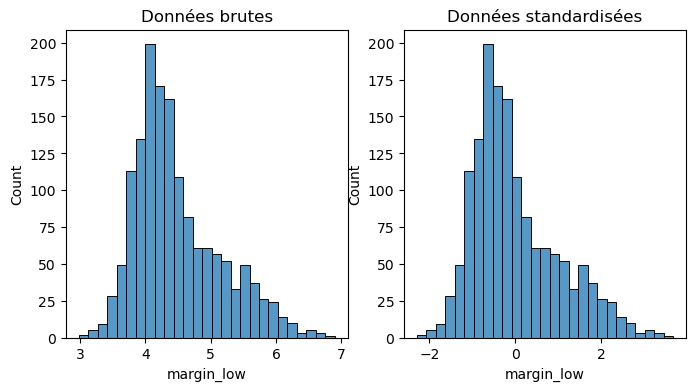

In [188]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(df['margin_low'], ax=ax[0])
sns.histplot(X_std['margin_low'], ax=ax[1])
ax[0].title.set_text('Données brutes')
ax[1].title.set_text('Données standardisées')
plt.show()

In [189]:
from sklearn.decomposition import PCA

matrix = X_std.cov()
matrix

diagonal  height_left  height_right  margin_low  margin_up  \
diagonal      1.000667     0.019485     -0.024508   -0.112255  -0.055686   
height_left   0.019485     1.000667      0.242440    0.303944   0.246687   
height_right -0.024508     0.242440      1.000667    0.396989   0.307209   
margin_low   -0.112255     0.303944      0.396989    1.000667   0.428539   
margin_up    -0.055686     0.246687      0.307209    0.428539   1.000667   
length        0.097652    -0.321077     -0.402019   -0.661120  -0.520922   

                length  
diagonal      0.097652  
height_left  -0.321077  
height_right -0.402019  
margin_low   -0.661120  
margin_up    -0.520922  
length        1.000667

In [190]:
n_components = 6

In [191]:
pca = PCA(n_components=n_components)

In [192]:
pca.fit(X_scaled)

PCA(n_components=6)

In [193]:
# Explication de variance du ratio

pca.explained_variance_ratio_

array([0.43145127, 0.169621  , 0.13031873, 0.11804926, 0.09614633,
       0.05441341])

In [194]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.15, 16.96, 13.03, 11.8 ,  9.61,  5.44])

In [195]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

In [196]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

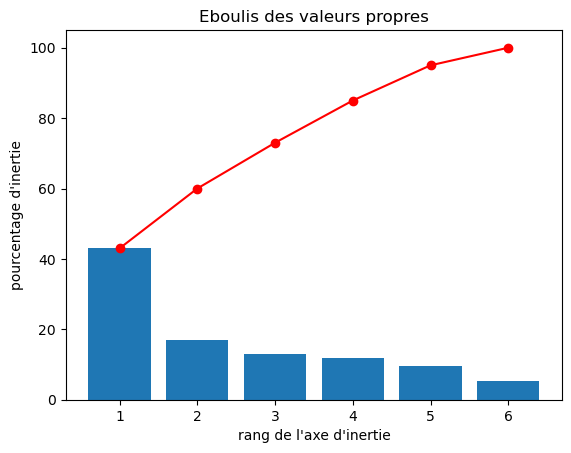

In [197]:
# Eboulis des valeurs propres

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

En appliquant l'observation du coude ici, ce n'est pas net du tout. Par ailleurs, 3 dimensions suffisent à justifier environ 73% de la variance.

In [198]:
# Les résultats PC de l'ACP

pcs = pca.components_
pcs

array([[-0.08551318,  0.33064173,  0.39616609,  0.50570894,  0.43973024,
        -0.52660398],
       [ 0.94056245,  0.30939628,  0.10782433, -0.07576214, -0.00305435,
         0.04733823],
       [-0.28906143,  0.88549472, -0.1708315 , -0.11385475, -0.26254227,
         0.14583499],
       [-0.09939669, -0.04405023,  0.85587501, -0.06594626, -0.46880755,
         0.17756241],
       [-0.12048217,  0.09348336,  0.26400945, -0.57726862,  0.69450212,
         0.30244282],
       [ 0.00880981,  0.01302018, -0.00446254,  0.62287053,  0.18864205,
         0.75906484]])

In [199]:
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5
0 -0.085513  0.330642  0.396166  0.505709  0.439730 -0.526604
1  0.940562  0.309396  0.107824 -0.075762 -0.003054  0.047338
2 -0.289061  0.885495 -0.170831 -0.113855 -0.262542  0.145835
3 -0.099397 -0.044050  0.855875 -0.065946 -0.468808  0.177562
4 -0.120482  0.093483  0.264009 -0.577269  0.694502  0.302443
5  0.008810  0.013020 -0.004463  0.622871  0.188642  0.759065

In [200]:
pcs.columns = X.columns
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

diagonal  height_left  height_right  margin_low  margin_up  length
F1     -0.09         0.33          0.40        0.51       0.44   -0.53
F2      0.94         0.31          0.11       -0.08      -0.00    0.05
F3     -0.29         0.89         -0.17       -0.11      -0.26    0.15
F4     -0.10        -0.04          0.86       -0.07      -0.47    0.18
F5     -0.12         0.09          0.26       -0.58       0.69    0.30
F6      0.01         0.01         -0.00        0.62       0.19    0.76

In [201]:
pcs.T

F1        F2        F3        F4        F5        F6
diagonal     -0.085513  0.940562 -0.289061 -0.099397 -0.120482  0.008810
height_left   0.330642  0.309396  0.885495 -0.044050  0.093483  0.013020
height_right  0.396166  0.107824 -0.170831  0.855875  0.264009 -0.004463
margin_low    0.505709 -0.075762 -0.113855 -0.065946 -0.577269  0.622871
margin_up     0.439730 -0.003054 -0.262542 -0.468808  0.694502  0.188642
length       -0.526604  0.047338  0.145835  0.177562  0.302443  0.759065

<AxesSubplot:>

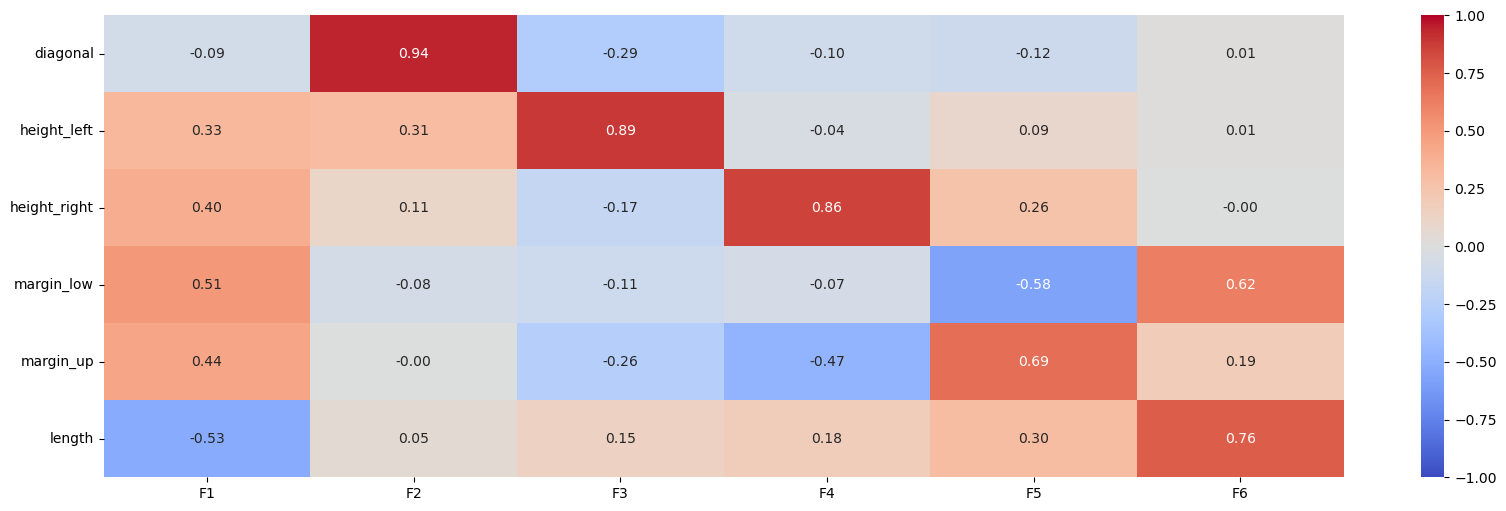

In [202]:
# Matrice des features

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [203]:
# Fonction du cercle de corrélations

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code, je l'ai lu et je l'ai compris
    # On set le titre du graph
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [204]:
x, y = 0,1

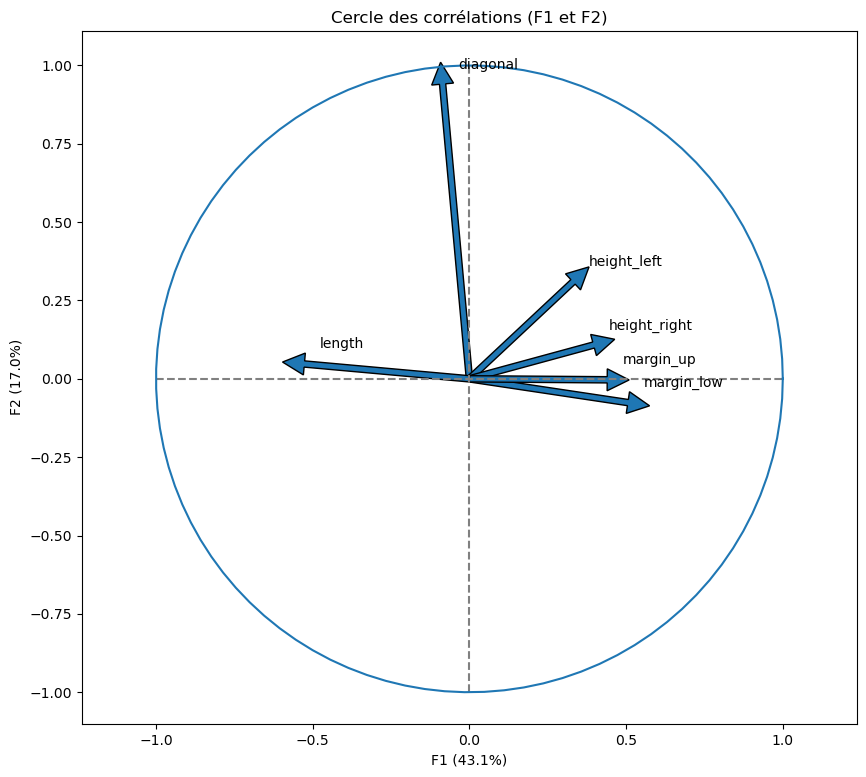

In [205]:
correlation_graph(pca, (0,1), X.columns)

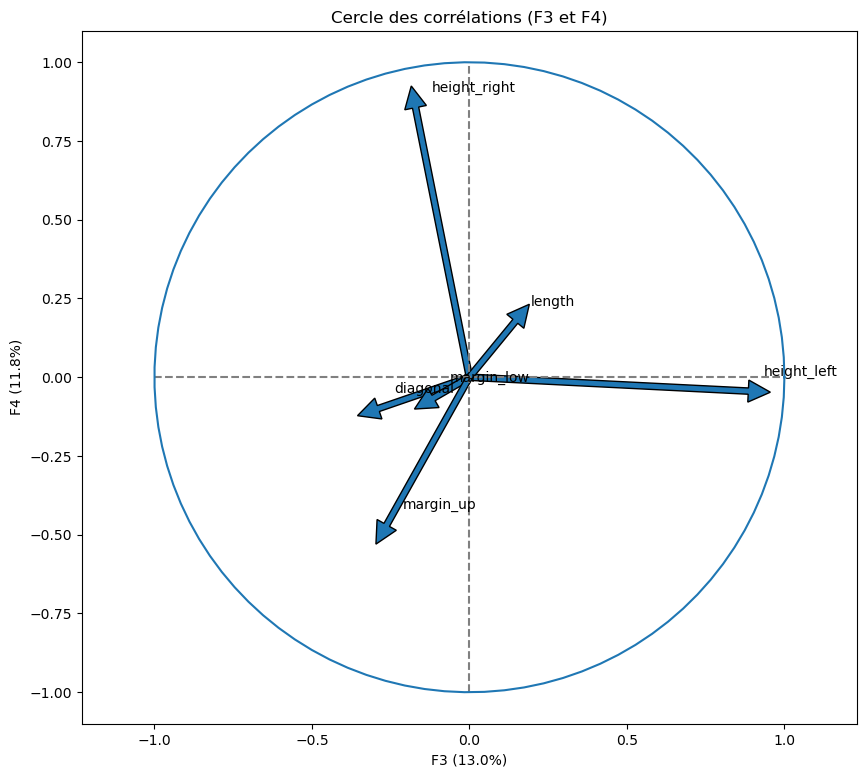

In [206]:
correlation_graph(pca, (2,3), X.columns)

In [207]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(X_std)

for i in range(0, n_components): 
    df['PC' + str(i + 1)] = reduced[:, i]
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95    4.520000       2.89   
1           True    171.46       103.36        103.66    3.770000       2.99   
2           True    172.69       104.48        103.50    4.400000       2.94   
3           True    171.36       103.91        103.94    3.620000       3.01   
4           True    171.73       104.28        103.46    4.040000       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    172.17       104.49        103.76    4.356655       2.93   
1496       False    172.08       104.15        104.17    4.684987       3.40   
1497       False    171.72       104.46        104.12    4.644947       3.61   
1498       False    172.66       104.33        104.41    4.877181       3.56   
1499       False    171.90       104.28        104.29    4.781084       3.24   

      length       PC1       PC2       PC3       PC4       PC5       PC6  
0     112.83  1.651325  0.749391  2.372228  3.189790  0.391252 -0.030171  
1     113.09 -2.021686 -2.207923 -0.995962  0.058669  0.063544 -0.491173  
2     113.16 -0.976393  2.620364  1.194718 -0.875372 -0.881267  0.212656  
3     113.51 -1.376426 -1.815207  0.652246  0.806586  0.839197 -0.234468  
4     112.54  0.144941 -0.558392  0.880631 -1.820842  1.122643 -0.264324  
...      ...       ...       ...       ...       ...       ...       ...  
1495  111.21  0.621513  1.013054  1.273407 -0.396115 -1.129807 -1.551314  
1496  112.29  1.262851  0.534555 -0.271031 -0.002732  0.626601  0.059170  
1497  110.31  3.208090 -0.377033  0.451302 -0.886321  0.803163 -1.526762  
1498  111.47  2.537660  2.519387 -0.765717 -0.097017  0.674815 -0.320548  
1499  111.49  1.856161  0.101366  0.251959  0.503513 -0.005665 -0.677209  

[1500 rows x 13 columns]

In [208]:
# Visualisation de nos deux groupes sur trois dimensions
import plotly.express as px
fig = px.scatter_3d(
    df, 
    x='PC1', y='PC2', z='PC3', color='is_genuine', symbol='is_genuine', opacity=.75)
fig.show()

On remarque bien sur le plan en trois dimensions que les vrais billets et faux billets sont bien distincts en deux groupes, qui peuvent arriver à se confondre à certains moments.

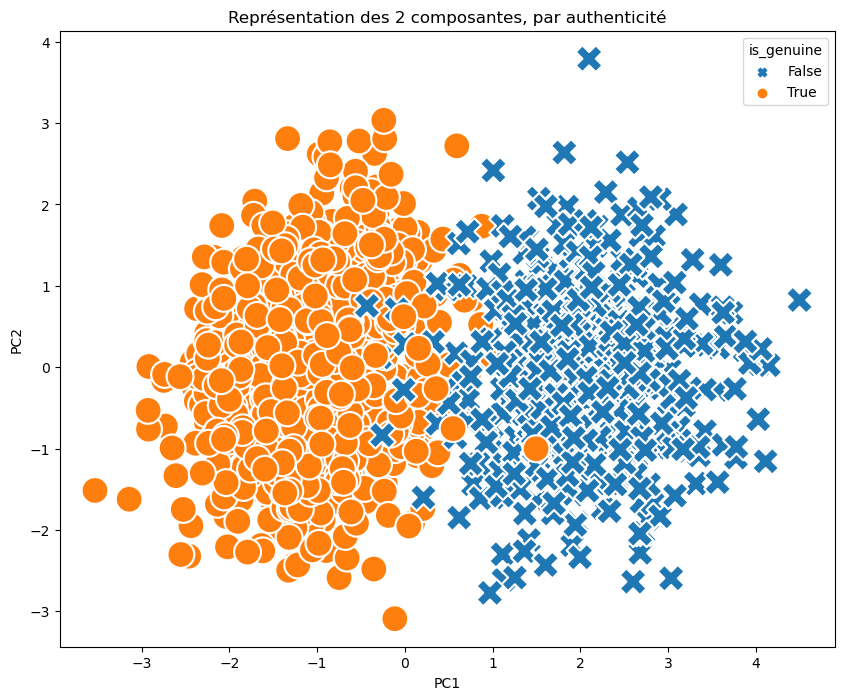

In [209]:
# ACP en 2 dimensions et plot de la 2d :
plt.figure(figsize=(10, 8))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers, s=375)
plt.title('Représentation des 2 composantes, par authenticité')
plt.show()

Il semble assez évident que nous devons utiliser 2 groupes ('True' et 'False') pour nos clusters mais voyons tout de même de plus près ce que disent les silhouettes de k-means ainsi que la méthode de coude.

For n_clusters = 2 The average silhouette_score is : 0.5124309177940309
For n_clusters = 3 The average silhouette_score is : 0.38444444756923607
For n_clusters = 4 The average silhouette_score is : 0.17196274382808505
For n_clusters = 5 The average silhouette_score is : 0.17225069895993905
For n_clusters = 6 The average silhouette_score is : 0.15686317410938902


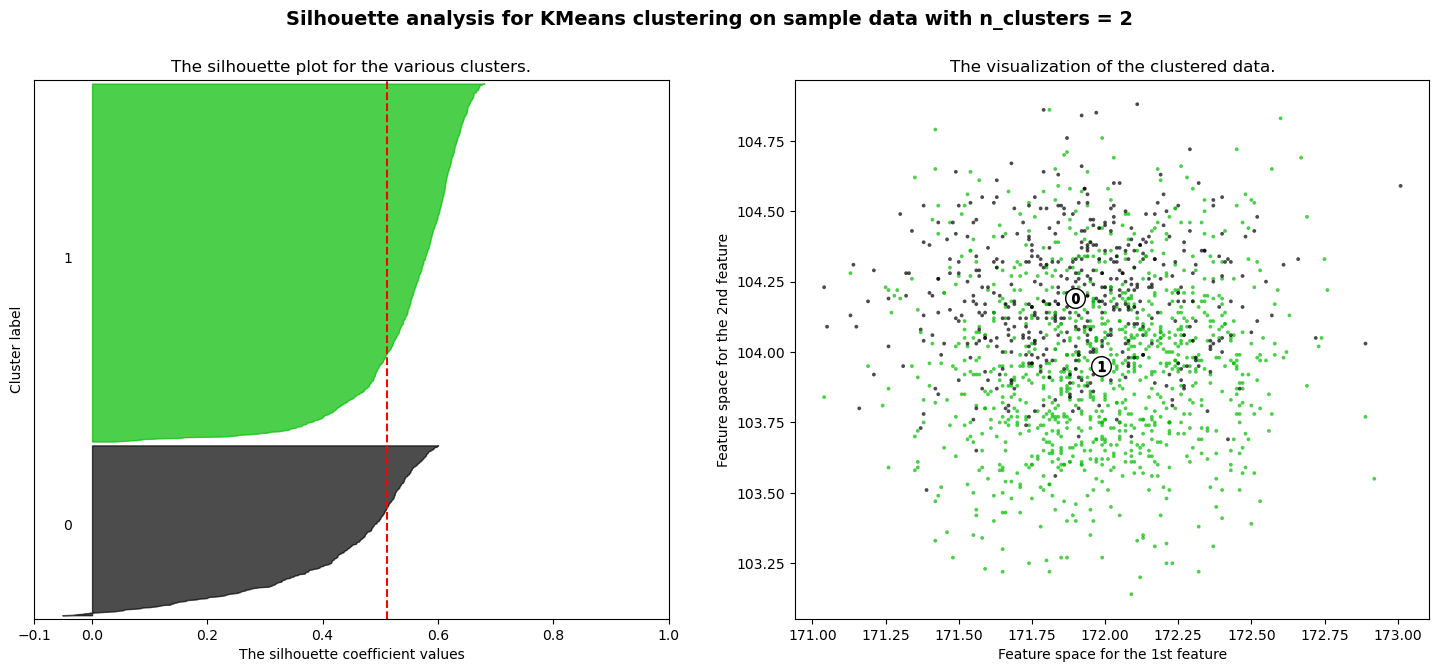

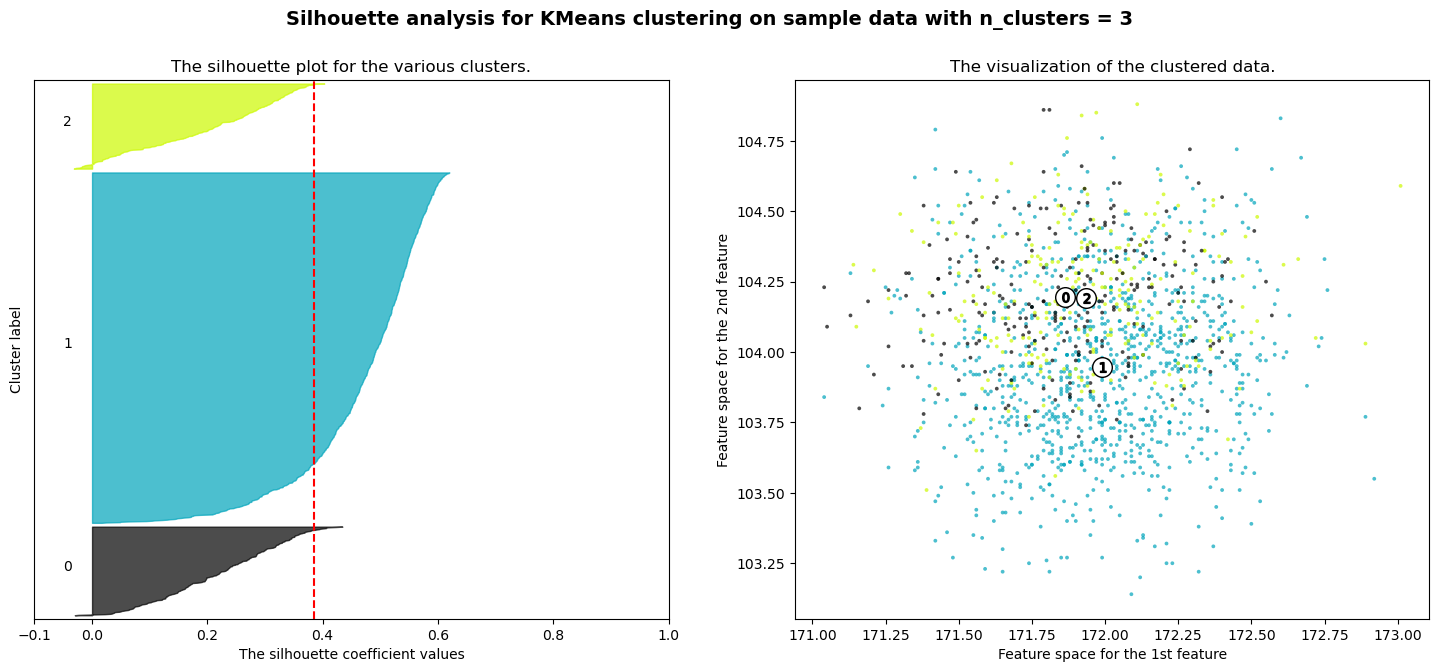

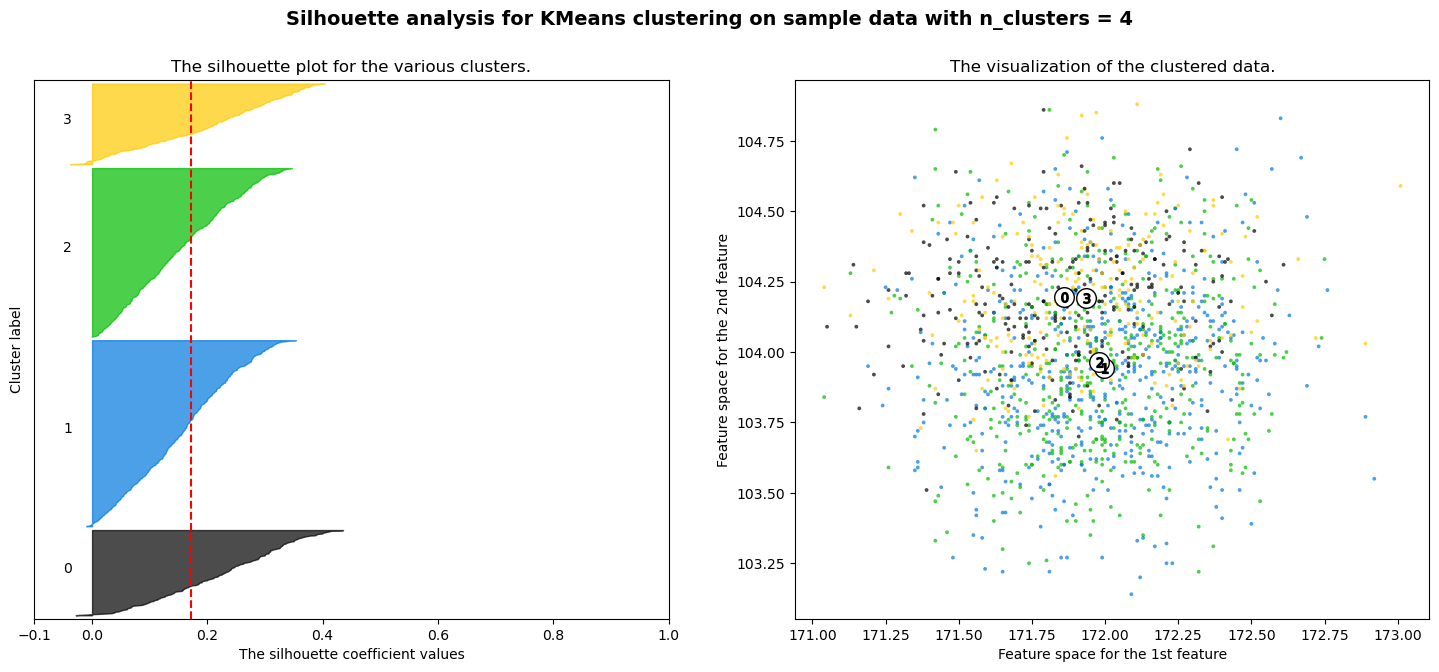

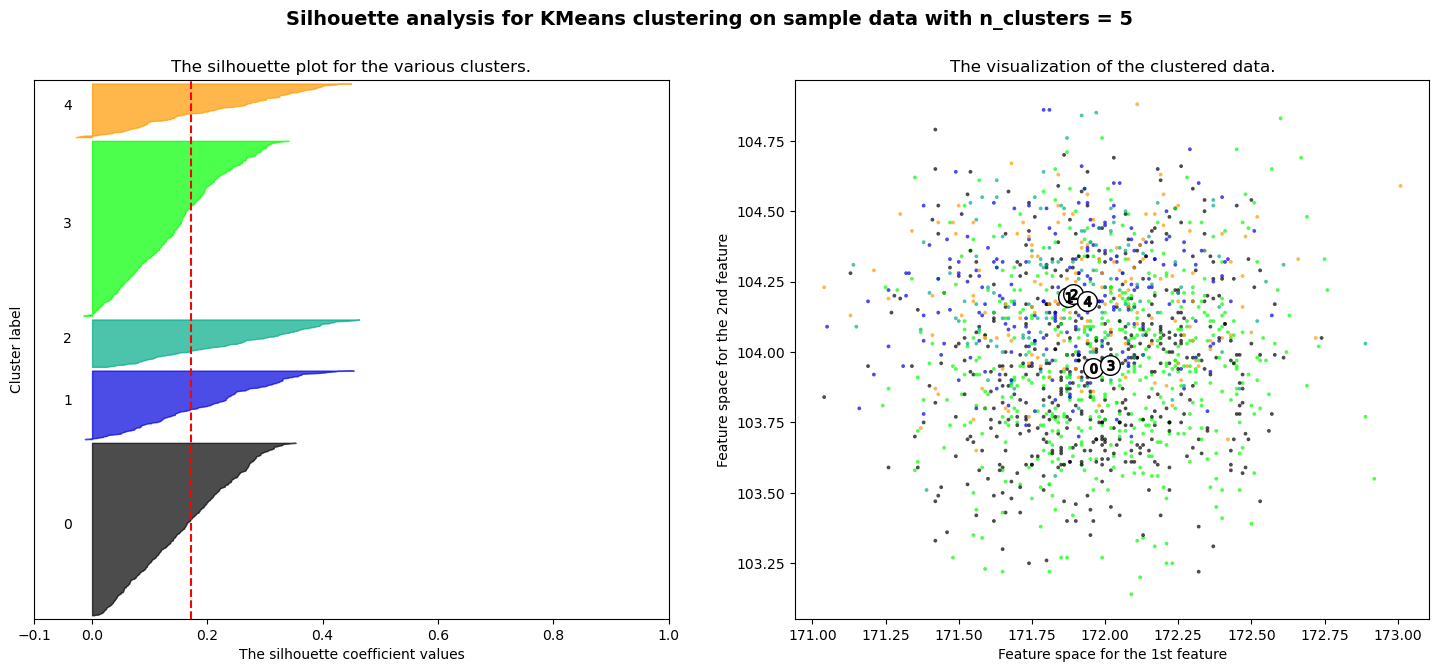

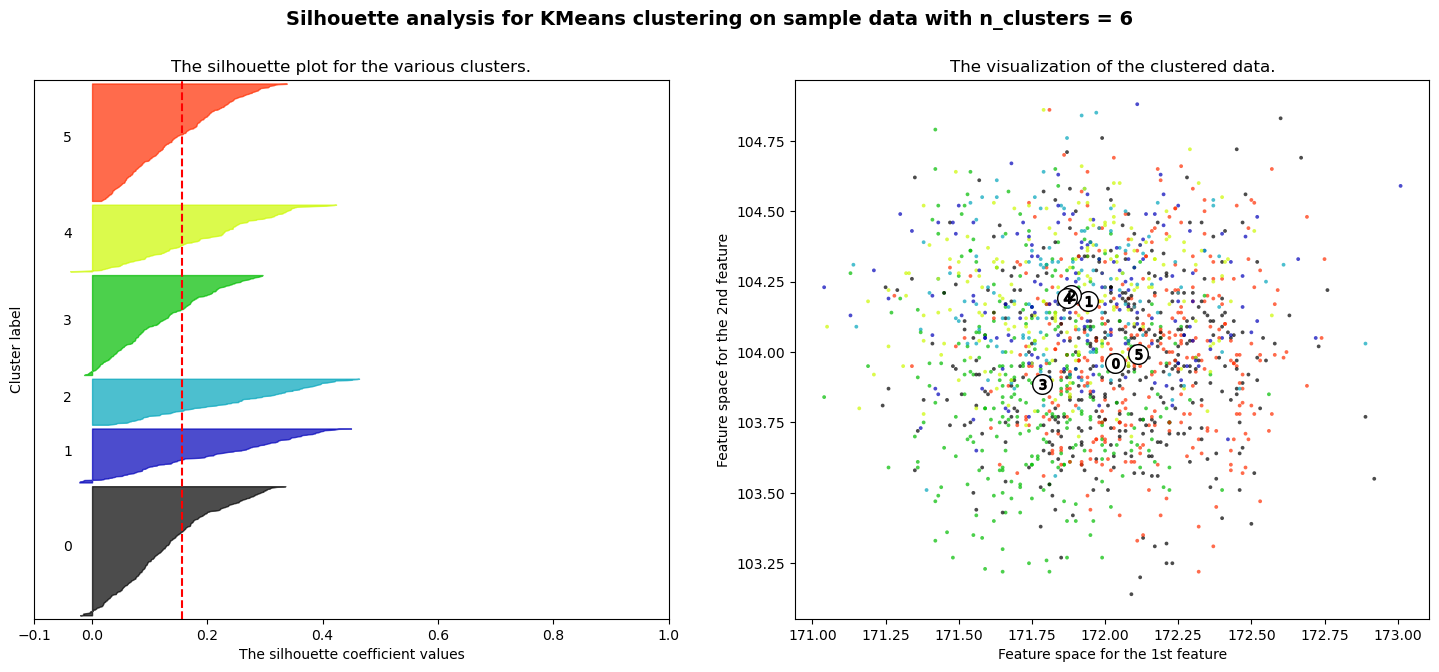

In [210]:
# Utilisation de l'analyse des silhouettes du kmeans

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters
                       , random_state=10
                      )
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    
plt.show()

De tous les nombres de clusters, c'est surtout le premier présenté, le nombre 2 qui indique des silhouettes presque similaires et dépassant le seuil de coefficience. Le nombre de 4 peut paraître intéressant aussi, si l'on ne prend pas en compte le volume de chaque groupe (2 groupes sont bien plus petits que les deux autres)

Aidons nous alors de la méthode du coude afin d'en avoir le coeur net

In [211]:
intertia = []

In [212]:
k_list = range(1, 10)
list(k_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [213]:
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X) 
  intertia.append(kmeans.inertia_)

In [214]:
# On charge nos valeurs d'inertie dans notre liste auparavant vide afin de les afficher plus tard

intertia

[2302.892300865214,
 976.2226288463667,
 865.6176187455093,
 777.8469283047814,
 712.5578514949718,
 666.8078891490708,
 632.0486607293418,
 596.5366350196816,
 573.4184747143372]

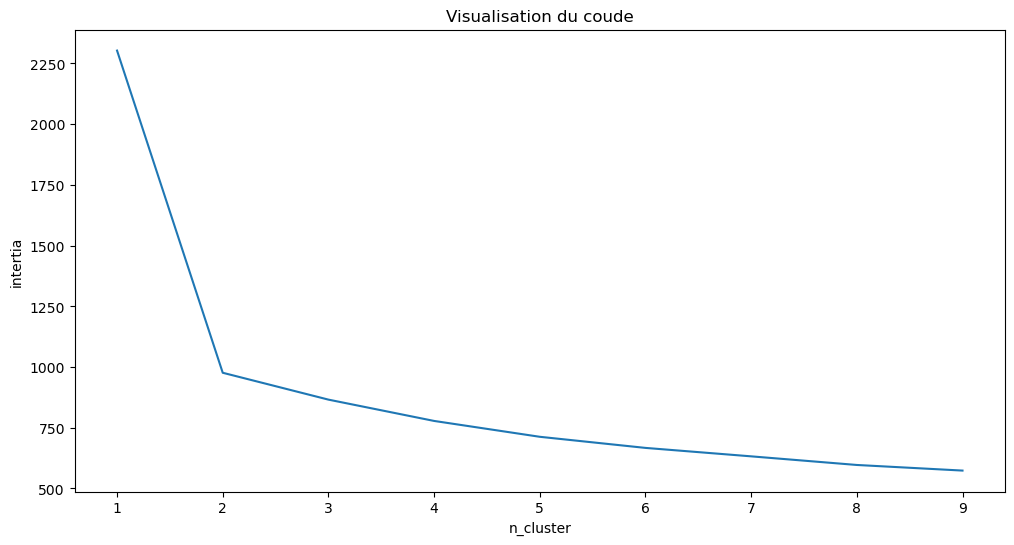

In [215]:
# Affichage du graphique du coude

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax.set_title("Visualisation du coude")
ax = plt.plot(k_list, intertia)

On peut visualiser un coude très net sur 2 clusters, il s'agit bien là donc de séparer en deux ('True' et 'False') notre jeu

In [216]:
k=2

In [217]:
# Edition de nos clusters
from sklearn import cluster

kmeans = sk.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
df['cluster'] = kmeans.predict(X)
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95    4.520000       2.89   
1           True    171.46       103.36        103.66    3.770000       2.99   
2           True    172.69       104.48        103.50    4.400000       2.94   
3           True    171.36       103.91        103.94    3.620000       3.01   
4           True    171.73       104.28        103.46    4.040000       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    172.17       104.49        103.76    4.356655       2.93   
1496       False    172.08       104.15        104.17    4.684987       3.40   
1497       False    171.72       104.46        104.12    4.644947       3.61   
1498       False    172.66       104.33        104.41    4.877181       3.56   
1499       False    171.90       104.28        104.29    4.781084       3.24   

      length       PC1       PC2       PC3       PC4       PC5       PC6  \
0     112.83  1.651325  0.749391  2.372228  3.189790  0.391252 -0.030171   
1     113.09 -2.021686 -2.207923 -0.995962  0.058669  0.063544 -0.491173   
2     113.16 -0.976393  2.620364  1.194718 -0.875372 -0.881267  0.212656   
3     113.51 -1.376426 -1.815207  0.652246  0.806586  0.839197 -0.234468   
4     112.54  0.144941 -0.558392  0.880631 -1.820842  1.122643 -0.264324   
...      ...       ...       ...       ...       ...       ...       ...   
1495  111.21  0.621513  1.013054  1.273407 -0.396115 -1.129807 -1.551314   
1496  112.29  1.262851  0.534555 -0.271031 -0.002732  0.626601  0.059170   
1497  110.31  3.208090 -0.377033  0.451302 -0.886321  0.803163 -1.526762   
1498  111.47  2.537660  2.519387 -0.765717 -0.097017  0.674815 -0.320548   
1499  111.49  1.856161  0.101366  0.251959  0.503513 -0.005665 -0.677209   

      cluster  
0           1  
1           1  
2           1  
3           1  
4           1  
...       ...  
1495        0  
1496        0  
1497        0  
1498        0  
1499        0  

[1500 rows x 14 columns]

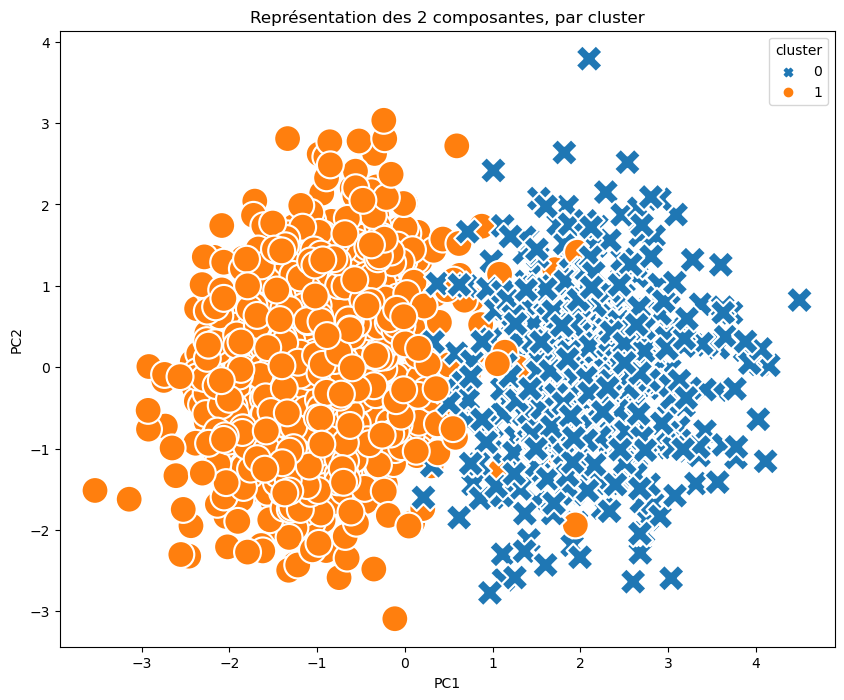

In [218]:
# Clusters sur 2 dimensions :
plt.figure(figsize=(10, 8))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='cluster', hue='cluster', markers=scatter_markers, s=375)
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

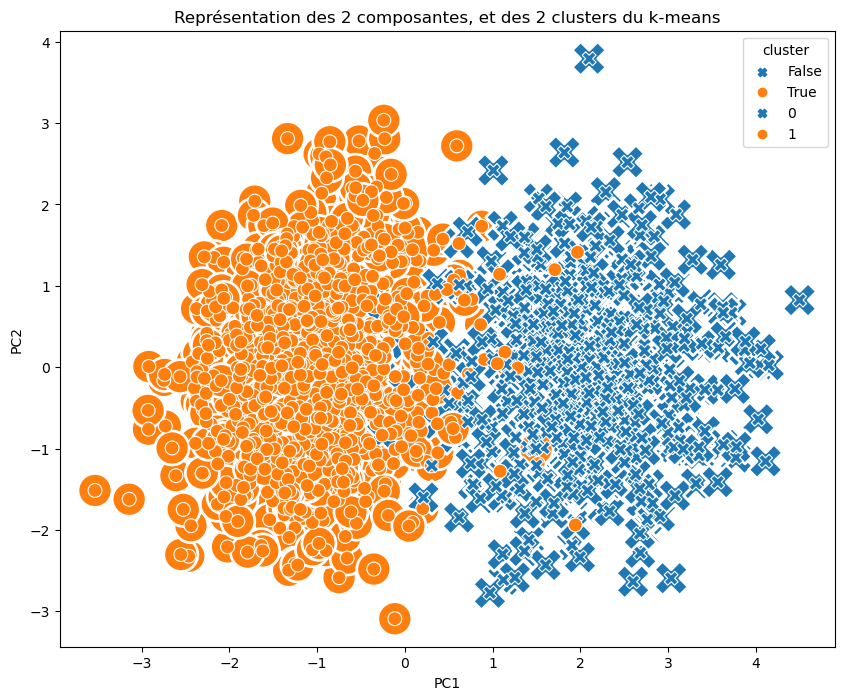

In [219]:
# Clusters et Vrais-Faux billets sur 2 dimensions :
plt.figure(figsize=(10, 8))
scatter_markers = ['X','o']
sns.scatterplot(data=df, x='PC1', y='PC2', style='is_genuine', hue='is_genuine', markers=scatter_markers, s=600)
sns.scatterplot(data=df, x='PC1', y='PC2', style='cluster', hue='cluster', markers=scatter_markers, s=100)
plt.title('Représentation des 2 composantes, et des 2 clusters du k-means')
plt.show()

On obtient certains faux parmi les cluster mais cela reste peu fréquent. Il faut essayer de voir cela dans une matrice de confusion

Matrice de confusion du clustering K-means :

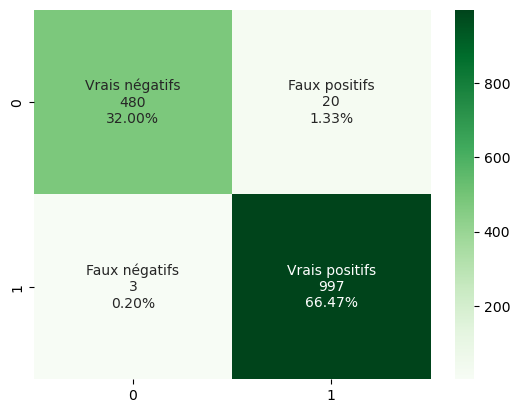

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       500
        True       0.98      1.00      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [220]:
def matrice_confusion(a, b):
    confusion_matrix = sk.metrics.confusion_matrix(a,b)
    group_names = ['Vrais négatifs','Faux positifs','Faux négatifs','Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = [
        '{0:.2%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Greens')
    plt.show()
    
    classification = sk.metrics.classification_report(a,b)
    print(classification)
    
matrice_confusion(df['is_genuine'], df['cluster'])
# Pour rappel : 0 = Faux et 1 = True pour les clusters

Regression logistique avec sklearn :

In [221]:
y = df['is_genuine']
y

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: bool

In [222]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_std, y, train_size=0.8)

In [223]:
regression = sk.linear_model.LogisticRegression()
regression.fit(xtrain, ytrain)

pd.DataFrame(
    regression.predict_proba(xtest)).rename(
    columns={0: 'False', 1: 'True'})

False      True
0    0.978342  0.021658
1    0.006780  0.993220
2    0.999938  0.000062
3    0.002177  0.997823
4    0.008059  0.991941
..        ...       ...
295  0.000795  0.999205
296  0.002858  0.997142
297  0.001499  0.998501
298  0.001438  0.998562
299  0.990016  0.009984

[300 rows x 2 columns]

In [224]:
regression.intercept_

array([2.16263819])

In [225]:
regression.coef_

array([[ 0.21105161, -0.60990501, -0.91673168, -2.67811155, -1.85167031,
         3.3798031 ]])

In [226]:
y_reg = regression.predict(xtest)

Matrice de confusion du modèle sklearn (regression logistique) :

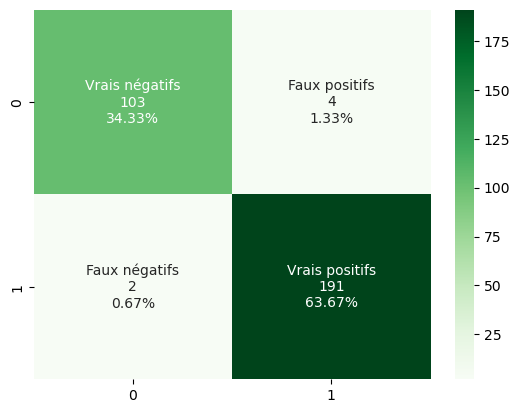

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       107
        True       0.98      0.99      0.98       193

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [227]:
matrice_confusion(ytest, y_reg)

In [228]:
from sklearn.metrics import accuracy_score
print('Taux de réussite du modèle :',(accuracy_score(ytest,y_reg)*100).round(2),'%')

Taux de réussite du modèle : 98.0 %


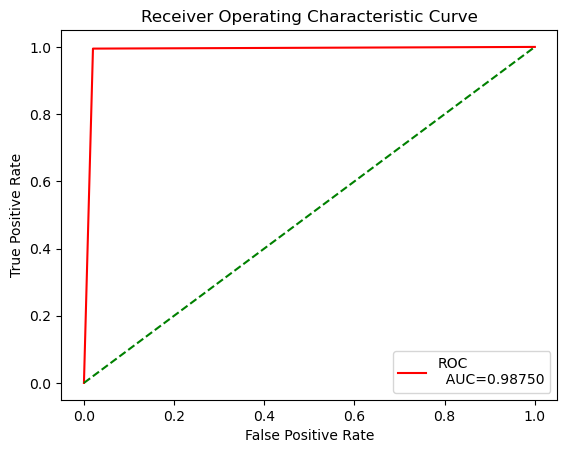

In [229]:
from sklearn import metrics
from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    aucf =metrics.auc(fper, tper)
    plt.plot(fper, tper, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = regression.predict(X_scaled)
fper, tper, thresholds = roc_curve(df['is_genuine'], prob)
plot_roc_curve(fper,tper )

Logistic: f1=0.994 auc=0.998


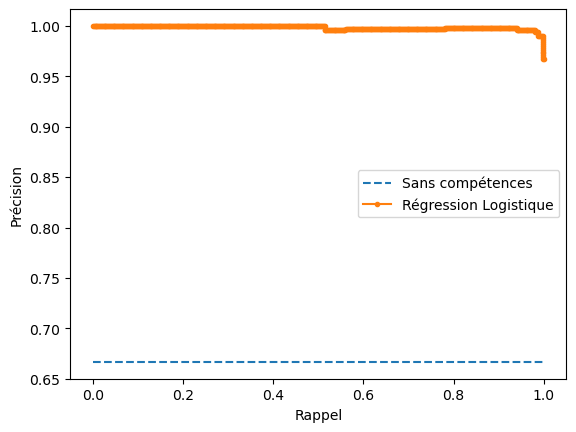

In [230]:
# precision-recall curve and f1
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X_std, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sans compétences')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Régression Logistique')
# axis labels
pyplot.xlabel('Rappel')
pyplot.ylabel('Précision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Regression logistique avec statsmodel

In [97]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

reg_multi = smf.glm('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             margin_low   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1493
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.17008
Method:                          IRLS   Log-Likelihood:                -796.28
Date:                Tue, 30 May 2023   Deviance:                       253.93
Time:                        11:49:43   Pearson chi2:                     254.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7863
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.7710      8

Les variables ayant une p-valeur inférieure à 0.5 sont significatives, on peut donc retirer les variables non significatives de la regression au fur et à mesure.

In [98]:
reg_multi = smf.glm('margin_low~is_genuine+height_left+height_right+margin_up+length', data=df).fit()
print(reg_multi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             margin_low   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1494
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                         0.17000
Method:                          IRLS   Log-Likelihood:                -796.44
Date:                Tue, 30 May 2023   Deviance:                       253.98
Time:                        11:50:08   Pearson chi2:                     254.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7864
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4524      5

In [99]:
reg_multi = smf.glm('margin_low~height_left+margin_up+length', data=df).fit()
print(reg_multi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             margin_low   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1496
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.23640
Method:                          IRLS   Log-Likelihood:                -1044.7
Date:                Tue, 30 May 2023   Deviance:                       353.65
Time:                        11:50:22   Pearson chi2:                     354.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5635
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      31.1969      5.448      5.727      

Les variables restantes étant toutes désormais inférieures à 0.5, on peut se servir du modèle actuel à des fins de prévision.
Voyons son pourcentage de chance d'être efficace.

Nous refaisons le modèle avec le dataframe préparé avec des variables 0 et 1 à la place des True ou False pour la variable is_genuine

In [100]:
reg_multi = smf.glm('is_genuine~margin_low+height_left+margin_up+length', data=df_1).fit()
print(reg_multi.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                        0.037319
Method:                          IRLS   Log-Likelihood:                 340.28
Date:                Tue, 30 May 2023   Deviance:                       55.793
Time:                        11:50:45   Pearson chi2:                     55.8
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9930
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.6776      2.188      8.079      

In [101]:
# Obtenir les prédictions du modèle
predictions = np.where(reg_multi.predict(df_1) > 0.5, 1, 0)

# Obtenir les vraies étiquettes (ground truth)
true_labels = df_1['is_genuine']

# Calculer l'accuracy score
accuracy = accuracy_score(true_labels, predictions)

print("Accuracy score:", accuracy)

Accuracy score: 0.986


Son taux de probabilté d'être efficace est de 98.6%. Ce qui est très correct mais reste en deça de notre deuxième modèle exploité avec scikit learn

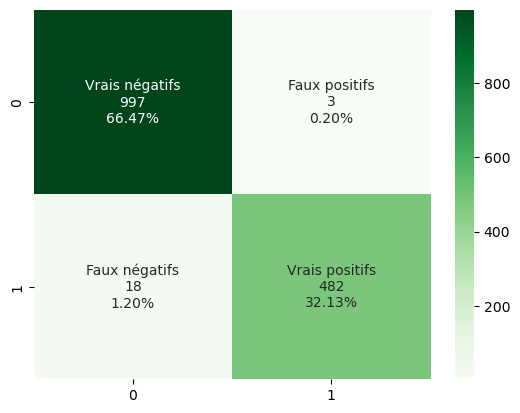

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       0.99      0.96      0.98       500

    accuracy                           0.99      1500
   macro avg       0.99      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500



In [102]:
matrice_confusion(true_labels, predictions)

La matrice de confusion nous indique en effet de très bons scores concernant le modèle de regression logistique de statsmodels.

ROC Curve sur le modèle de statsmodels :

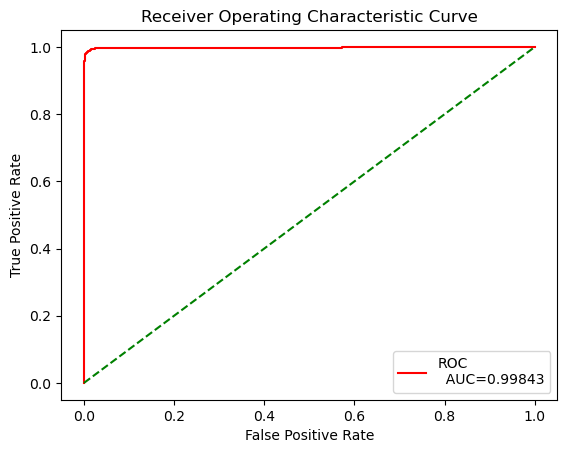

In [103]:
prob = reg_multi.predict(df_1)
fper, tper, thresholds = roc_curve(df_1['is_genuine'], prob)
plot_roc_curve(fper,tper )

Nous choisissons le modèle proposé par scikit learn au vu des résultats qu'il procure.

In [231]:
train_dict = {}
train_dict[0] = regression

In [232]:
import pickle

pickle.dump(train_dict, open('train.p', 'wb'))

In [233]:
print(train_dict)

{0: LogisticRegression()}


In [234]:
joblib.dump(regression, 'modele_regression.joblib')

['modele_regression.joblib']

__Dernière partie : Fonction de détection__

Les fichiers fournis doivent suivre la même composition que suit: 
(A noter qu'il est admis qu'il puisse y avoir des valeurs manquantes au sein de la colonne 'margin_low')

In [191]:
billets_csv = '/Users/Kévin/Downloads/OPENCLASSROOM/P10/billets_production.csv'
# ----------------------------------------------------------------------------------
billets = pd.read_csv(billets_csv, encoding='utf-8', sep=',')
# ----------------------------------------------------------------------------------
# Visualisation df
billets

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

__Programme de détection__

Marche à suivre :


- Veuillez déposer le fichier dans le dossier racine habituel.

- Puis, suivre l'indication 1 du code ci-contre, remplir le nom du fichier entre côtes

- Exécutez le node ci-dessous à la suite de quoi vous pourrez accéder aux résultats fournis dans le même dossier racine que pour le dépôt

Merci

In [235]:
# Date : 26/05/2023
# Auteur : Kévin Bergeron, Data Analyst

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pickle
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import json
import joblib

import warnings
warnings.simplefilter("ignore")

pd.options.mode.chained_assignment = None  # default='warn'


# variable : fichier
# Le fichier est à déposer toujours dans le même dossier racine
# Indication 1 : Remplir ici le nom du fichier que l'on veut analyser
# ----------------------------------------------------------------------------------
fichier = 'billets_production.csv'                                                #|
# ----------------------------------------------------------------------------------

# Chemin du fichier (do not modify without prior authorization)
path = '/Users/Kévin/Downloads/OPENCLASSROOM/P10/'
# Définition du chemin complet du fichier (do not modify without prior authorization)
billets_csv = (f'{path.format(path=path)}{fichier.format(fichier=fichier)}')


# Fonctions utilisées (do not modify without prior authorization)

# Fonction vérifier les valeurs nulles après lecture
def verifier_valeurs_nulles(dataframe, colonne):
    
    valeurs_nulles = dataframe[colonne].isnull().any()
    
    return valeurs_nulles

# Fonction pour lire le fichier
def lire(file):
    
    # Lecture du fichier
    df = pd.read_csv(file, encoding='utf-8', sep=',')
    print('fichier initial :\n',df)
    
    return df
    
# Fonction pour vérifier les valeurs à nulles éventuellement présentes dans la colonne margin_low
def verifier(df):
    
    colonnes_verifiees = 'margin_low'
    
    result = verifier_valeurs_nulles(df, colonnes_verifiees)

    return df, result

# Fonction de regression linéaire pour combler les valeurs à nul
def regression_lineaire(df, colonnes_true):
    
    df_resultat, liste_colonnes = colonnes_true
    
    # On applique la regression linéaire si il y a des valeurs manquantes dans la colonne margin_low
    if liste_colonnes == True:
        sans_null = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index().drop(['index'], axis=1)
        print('sans_null :\n',sans_null)
        
        test_df = df[df.isna().any(axis=1)]
        print('df_null :\n',test_df)

        reg = LinearRegression()
        reg.fit(sans_null[['length']], sans_null['margin_low'])

        test_df['margin_low'] = reg.predict(test_df[['length']])
        print('prediction :\n',test_df)
        df = pd.concat([sans_null, test_df], ignore_index=True)
        print("\nRegression linéaire appliquée, puisque il y a une ou plusieurs valeur(s) manquante(s) dans la colonne margin_low\n")
        print("Jeu à l'étude, avec regression linéaire :\n",df)
        # Export fichier à la racine
        nomFichier = 'dataframe_final'
        date_now = datetime.today()
        date_now = date_now.strftime("%Y%m%d")
        filename = "{nomFichier}_{date}.csv".format(nomFichier=nomFichier,date=date_now)
        print("\nVeuillez retrouver le dataframe_final en csv exporté suivant :",filename)
        df.to_csv(f'{path.format(path=path)}{filename.format(filename=filename)}', index=False, sep=';')
        return df
    else:
        print("\nAucune regression linéaire appliquée, puisque aucune valeur manquante dans la colonne margin_low\n")
        print("Jeu à l'étude, sans regression linéaire :\n",df)
        # Export fichier à la racine
        nomFichier = 'dataframe_final'
        date_now = datetime.today()
        date_now = date_now.strftime("%Y%m%d")
        filename = "{nomFichier}_{date}.csv".format(nomFichier=nomFichier,date=date_now)
        print("\nVeuillez retrouver le dataframe_final en csv exporté suivant :",filename)
        df.to_csv(f'{path.format(path=path)}{filename.format(filename=filename)}', index=False, sep=';')
        return df

# Fonction de detection
def detection(dataframe):

    # Récupération des paramètres de notre modèle
    train_dict = pickle.load(open('train.p', 'rb'))
    regression = train_dict[0]
    
    #Standardisation des valeurs
    X_csv = dataframe.drop(['id'], axis=1)
    scaler = StandardScaler()
    scaler.fit(X_csv)
    X_csv_scaled = scaler.transform(X_csv)
    X_csv_std = pd.DataFrame(X_csv_scaled, columns=X_csv.columns)
    
    # Regression logistique avec le modèle déjà entraîné (scikit-learn) du fichier pickle
    y_log = regression.predict(X_csv_std)
    predictions = []
    for i in range(0, len(y_log)):
        predictions.append(y_log[i])
    
    predictions = pd.concat([
        pd.DataFrame(
        [predictions]).rename(index={0: 'Prédiction'}).T.replace(
        {False: 'Faux billet', True: 'Vrai billet'}),
        pd.DataFrame(
        regression.predict_proba(X_csv_std)).rename(
        columns={0: 'Probabilité de faux', 1: 'Probabilité de vrai'})], axis=1)
    predictions['id'] = dataframe['id'].unique()
    
    print('\nPREDICTIONS :\n',predictions)
    
    # Export fichier à la racine
    nomFichier = 'resultat_billets'
    date_now = datetime.today()
    date_now = date_now.strftime("%Y%m%d")
    filename = "{nomFichier}_{date}.csv".format(nomFichier=nomFichier,date=date_now)
    print("\nVeuillez retrouver le fichier csv exporté suivant :",filename)
    

    predictions.to_csv(f'{path.format(path=path)}{filename.format(filename=filename)}', index=False, sep=';')

    return predictions
  
    
    
########## MAIN ##########

# Fonction principale qui s'occupe de lancer tout le programme de détection
def main():
    
    mon_df = lire(billets_csv)
    
    colonnes_true = verifier(mon_df)
    
    df_final = regression_lineaire(mon_df, colonnes_true)
    
    predictions = detection(df_final)
    
    jeu_df = df_final.merge(predictions, how="left", left_on="id", right_on="id")
    
    # Export dataframe final à la racine
    nomFichier = 'jeu_final_predictions'
    date_now = datetime.today()
    date_now = date_now.strftime("%Y%m%d")
    filename = "{nomFichier}_{date}.csv".format(nomFichier=nomFichier,date=date_now)
    print("\nVeuillez retrouver le jeu final (avec predictions) en csv exporté suivant :",filename)

    jeu_df.to_csv(f'{path.format(path=path)}{filename.format(filename=filename)}', index=False, sep=';')

if __name__ == "__main__":
    main()

fichier initial :
    diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

Aucune regression linéaire appliquée, puisque aucune valeur manquante dans la colonne margin_low

Jeu à l'étude, sans regression linéaire :
    diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65   

In [ ]:
# # Etapes déjà produites :

# - lecture dataframe
# - détection doublons
# - appréhension jeu
# - vérif des valeurs uniques
# - visualisation du pourcentage de null
# - première matrice de corrélations
# - regression linéaire pour combler les valeurs nulles
# - jointure propre des nouvelles imputations de margin_low à la place des null
# - vérif plus de NaN et bien 1500 lignes
# - deuxième matrice de corrélation pour vérif
# - deux plots : histo et pie pour visu de la distribution des vrais/faux du jeu
# - pairplot du jeu
# - rappel de la matrice de corrélation et boxplot des deux variables semblant faire le plus d'impact sur is_genuine
# - standardisation des variables
# - ACP à 6 composantes
# - éboulis des valeurs propres
# - matrice des features sur les plans factoriels
# - graphiques de corrélation
# - visualisation sur trois dimensions des deux groupes
# - visualisation en deux dimensions des deux groupes (scatter)
# - clustering k-means
# - visualisation k-means et vrai jeu pour voir les différences
# - matrice de confusion avec les résultats du k-means
# - compartimentation du jeu en train et test 
# - regression logistique avec sklearn
# - matrice de confusion avec les résultats de la regression logistique sur le jeu test
# - Pourcentage de performance du modèle de regression logistique sklearn
# Méthode des silhouettes et coude sur le k-means pour décision des 2 groupes
# Vérifier toutes les hypothèses sous jacentes du modèle linaire (du début) : homoscédasticité, multi colinéarité,
# normalité des résidus
# Calculer le coefficient R² dans la regression linéaire du début
# Calculer les métriques de performance des k-means : recall et accuracy avec la matrice de confusion
# Regression linéaire sans la variable diagonal et cela ne change pas le R², on pourrait retirer la variable du jeu.
# ?? Afficher le pourcentage de réussite du modèle clustering k-means ? (accuracy_score de sklearn.metrics ?)
# ?? DEJA FAIT dans la matrice Prendre le recall avec l'accuracy sur le premier modèle, afficher le recall sur le deuxième modèle aussi
# Regression logistique avec statsmodel 
# Elimination des variables pas à pas : Regression logistique sans la variable diagonal ? 
# Voir comment cela se comporte au niveau du R² si c'est mieux 
# (l'afficher avant, supprimer la variable diagonal et réafficher le R²)
# Afficher le pourcentage de réussite du modèle regression logistique de statsmodel 
# Courbe ROC sur le modèle choisi final : Entre k-means, scikit learn reglog et statsmodel reglog (uniquement si regression logistique bien sur)
# Enregistrer le modèle le plus performant avec le pickle
# Fonction du détecteur pour test live
# Fonctions du main de détection :
# - vérif de margin_low à vide ou pas
# - regression linéaire si True
# - regression logistique sur le df renvoyé
# - visualisation de la prédiction avec le modèle utilisé et le pourcentage de proba que le résultat soit faux/vrai

# # FACULTATIF :
# Intégrer dans le détecteur une détection de valeurs nulles et printer en cas de valeurs nulles que le modèle risque de planter
# Essayer de voir pour intégrer un try catch (if) au niveau des valeurs nulles genre si y'a valeurs nulles, alors faire une
# regression linéaire et concaténer les données sur l'index comme fait plus haut mais intégré au if du détecteur dans
# la détection de valeurs nulles.
# Ajouter aux résultats des modèles les probabilités que le billet soit faux et que le billet soit vrai (.predict_proba())


In [ ]:
# # A faire :

# méthode smot
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

# courbe précision recall à ajouter sur le modèle scikit learn (maximise la précision, diminue le recall)
# Justifier par rapport au métier, les choix appliqués sur le recall.
# interface avec streamlit
# streamlit ou flask (créer une appli avec export pickle + interface, import csv import pickle)

In [ ]:
# Voir pour installer nb extension et rise dans jupyter
# (mise en page de code pour présentation type slide)
# Voir pour la librairie altair : affichage différents des plot.

In [ ]:
# Questions possibles à la soutenance:
# Quel autre moyen que GridSearch j'aurais pu utiliser pour déterminer le nb optimal de voisins ? 
# (c'est pas dans le cours il me semble, mais RandomSearch par exemple)

# Dans une situation ou notre dataset est très déséquilibré (genre 100 faux billets et 2 vrais billets), 
# quels sont les risques et comment peut-on les prévenir ?

# Différences entre regression logistique de statsmodel et celle de sklearn ?